# Quantum Key Distribution and Eavesdropper

## Contents

1. Ordinary measurement method of eavesdropper
2. Another measurement method of eavesdropper (eavesdropper with angle)
3. Result of performance evaluation

## 1. Ordinary measurement method of eavesdropper

This example uses the BB84 QKD (quantum key distribution) protocol where Alice sends qbits to Bob. 
Eavesdropper (Eve) uses a measurement in the X-basis or a measurement in the Z-basis for every qbit communication between Alice and Bob.

Alice --> Eve -> Bob

After Alice and Bob remove any bits where Bob measured a different basis than Alice prepared,
there are four cases.

| case | Alice's basis | Eve's basis | Bob's basis | probability | P(Alice==Bob\|case) | P(Alice==Eve\|case) | P(Bob==Eve\|case) |
|:----:|:-------------:|:-----------:|:-----------:|:-----------:|:-------------------:|:-------------------:|:-----------------:| 
| 1    | X-basis       | X-basis     | X-basis     | 1/4         | 1                   | 1                   | 1                 |
| 2    | X-basis       | Z-basis     | X-basis     | 1/4         | 1/2                 | 1/2                 | 1/2               |
| 3    | Z-basis       | X-basis     | Z-basis     | 1/4         | 1/2                 | 1/2                 | 1/2               |
| 4    | Z-basis       | Z-basis     | Z-basis     | 1/4         | 1                   | 1                   | 1                 |

P(Alice == Bob), the probability that Alice's bit is equal to Bob's bit, is
0.75 (=1/4 * 1 +  1/4 * 1/2 + 1/4 * 1/2 + 1/4 * 1).

P(Alice == Eve), the probability that Alice's bit is equal to Eve's bit, is
0.75 (=1/4 * 1 +  1/4 * 1/2 + 1/4 * 1/2 + 1/4 * 1).

P(Bob == Eve), the probability that Bob's bit is equal to Eve's bit, is
0.75 (=1/4 * 1 +  1/4 * 1/2 + 1/4 * 1/2 + 1/4 * 1).

Alice and Bob compare the values of the check bits.
If more than an acceptable number disagree, P(Alice == Bob) < acceptable p, they abort the protocol.
If Alice and Bob decide to proceed the protocol, the rate that Eve succesfully gets Bob's key is P(Bob == Eve).

## 2. Another measurement method of eavesdropper (eavesdropper with angle)

A measurement in the Z-basis is equal to a measurement in the X-basis with a Hadamard gate in front and a Hadamard gate in the rear, $H-X-H$.
It looks like a interesting idea to extend this measurement.
Eve uses another measurement in the X-basis with a U-gate#1 in front and a U-gate#2 in the rear, $U_1-X-U_2$.
In this example, $U_1$ and $U_2$ are defined as follows.

$$
U_1 = U_2 =
\left(
\begin{matrix} 
cos(\theta/2) & sin(\theta/2) \\ 
sin(\theta/2) & -cos(\theta/2) 
\end{matrix}
\right)
$$

$U_1$ and $U_2$ rotate the phase of state. So, I call this method as "eavesdropper with angle". 

To evaluate the performance, P(Alice == Bob) and P(Bob == Eve) are calculated below.

In [1]:
# import
import numpy as np
import itertools
from math import pi
import matplotlib.pyplot as plt

#%matplotlib inline

from qiskit import (
    QuantumCircuit,
    ClassicalRegister,
    QuantumRegister,
    execute,
    BasicAer,
    Aer,
    transpile,
    assemble,
)
from qiskit.visualization import plot_histogram, plot_bloch_multivector

print("Imports Successful")


Imports Successful


In [2]:
def calc_theta(p):
    return 2 * np.arccos(np.sqrt(p))


def fill_result(result):
    bit_len = len(list(result.keys())[0])
    bit = ["0", "1"]
    key_list = ["".join(bits) for bits in itertools.product(bit, repeat=bit_len)]

    total = sum(result.values())
    result_new = {}
    for k in key_list:
        v = result.get(k)
        result_new[k] = 0 if v is None else v / total
    return result_new


def count_result(result, filter_str):
    bit_list = []
    for bit_str in filter_str:
        if bit_str == "0" or bit_str == "1":
            bit_list.append([bit_str])
        else:
            bit_list.append(["0", "1"])
    key_list = ["".join(bits) for bits in itertools.product(*bit_list)]

    total = 0
    for k in key_list:
        total += result[k]

    return total


In [3]:
def make_qkd_qc(b, zx, p, angle):
    theta = calc_theta(p)
    qc = QuantumCircuit(3, 2)
    qc.u(theta, 0, 0, 0)
    if b == 1:
        qc.x(1)
    if zx == 1:
        qc.h(1)
    # control swap (cswap) is used to switch applying a measurement with rate p.
    # - no swapping and applying a measurement with probability p
    # - swapping and applying no measurement with probability 1-p (swap p is defined as 1-p)
    qc.cswap(0, 1, 2)
    qc.u(angle, 0, pi, 1)
    qc.measure(1, 0)
    qc.u(angle, 0, pi, 1)
    qc.cswap(0, 1, 2)
    if zx == 1:
        qc.h(1)
    qc.measure(1, 1)
    return qc


def qkd(b, zx, p, angle):
    qc = make_qkd_qc(b, zx, p, angle)
    aer_sim = Aer.get_backend("aer_simulator")
    job = aer_sim.run(assemble(qc), shots=4096)
    return job.result().get_counts()


def calc_prob(result):
    total = 0
    for k, v in result.items():
        total += v
    result_tmp = {}
    for k in ["00", "01", "10", "11"]:
        v = result.get(k)
        if v is None:
            result_tmp[k] = 0
        else:
            result_tmp[k] = v / total
    return result_tmp


def calc_statistics(p, angle):
    q = {}
    q["z0"] = fill_result(qkd(0, 0, p, angle))
    q["z1"] = fill_result(qkd(1, 0, p, angle))
    q["x0"] = fill_result(qkd(0, 1, p, angle))
    q["x1"] = fill_result(qkd(1, 1, p, angle))
    p_acc = (
        1.0 / 4 * (q["z0"]["00"] + q["z0"]["01"])
        + 1.0 / 4 * (q["z1"]["10"] + q["z1"]["11"])
        + 1.0 / 4 * (q["x0"]["00"] + q["x0"]["01"])
        + 1.0 / 4 * (q["x1"]["10"] + q["x1"]["11"])
    )

    p0_suc = 0
    if q["z0"]["00"] + q["z0"]["10"] + q["z1"]["00"] + q["z1"]["10"] > 0:
        p0_suc += (
            1.0
            / 2
            * (
                (q["z0"]["00"] + q["z1"]["00"])
                / (q["z0"]["00"] + q["z0"]["10"] + q["z1"]["00"] + q["z1"]["10"])
            )
        )
    if q["x0"]["00"] + q["x0"]["10"] + q["x1"]["00"] + q["x1"]["10"] > 0:
        p0_suc += (
            1.0
            / 2
            * (
                (q["x0"]["00"] + q["x1"]["00"])
                / (q["x0"]["00"] + q["x0"]["10"] + q["x1"]["00"] + q["x1"]["10"])
            )
        )
    p1_suc = 0
    if q["z0"]["01"] + q["z0"]["11"] + q["z1"]["01"] + q["z1"]["11"] > 0:
        p1_suc += (
            1.0
            / 2
            * (
                (q["z0"]["11"] + q["z1"]["11"])
                / (q["z0"]["01"] + q["z0"]["11"] + q["z1"]["01"] + q["z1"]["11"])
            )
        )
    if q["x0"]["01"] + q["x0"]["11"] + q["x1"]["01"] + q["x1"]["11"] > 0:
        p1_suc += (
            1.0
            / 2
            * (
                (q["x0"]["11"] + q["x1"]["11"])
                / (q["x0"]["01"] + q["x0"]["11"] + q["x1"]["01"] + q["x1"]["11"])
            )
        )

    p0_eve = (
        1.0 / 4 * count_result(q["z0"], "*0")
        + 1.0 / 4 * count_result(q["z1"], "*0")
        + 1.0 / 4 * count_result(q["x0"], "*0")
        + 1.0 / 4 * count_result(q["x1"], "*0")
    )
    p1_eve = (
        1.0 / 4 * count_result(q["z0"], "*1")
        + 1.0 / 4 * count_result(q["z1"], "*1")
        + 1.0 / 4 * count_result(q["x0"], "*1")
        + 1.0 / 4 * count_result(q["x1"], "*1")
    )
    p_suc = (
        1.0
        / 4
        * (
            q["z0"]["00"]
            + q["z0"]["11"]
            + q["z1"]["00"]
            + q["z1"]["11"]
            + q["x0"]["00"]
            + q["x0"]["11"]
            + q["x1"]["00"]
            + q["x1"]["11"]
        )
    )
    return p_acc, p0_suc, p1_suc, p0_eve, p1_eve, p_suc


def eval_performance():
    p_list = np.linspace(0, 1, 11)
    angle_list = pi * np.linspace(-1, 1, 21)
    p_acc_mat = np.zeros((len(p_list), len(angle_list)))
    p0_suc_mat = np.zeros((len(p_list), len(angle_list)))
    p1_suc_mat = np.zeros((len(p_list), len(angle_list)))
    p0_eve_mat = np.zeros((len(p_list), len(angle_list)))
    p1_eve_mat = np.zeros((len(p_list), len(angle_list)))
    p_suc_mat = np.zeros((len(p_list), len(angle_list)))
    p_idx = 0
    for p in p_list:
        angle_idx = 0
        for angle in angle_list:
            p_acc, p0_suc, p1_suc, p0_eve, p1_eve, p_suc = calc_statistics(p, angle)
            p_acc_mat[p_idx, angle_idx] = p_acc
            p0_suc_mat[p_idx, angle_idx] = p0_suc
            p1_suc_mat[p_idx, angle_idx] = p1_suc
            p0_eve_mat[p_idx, angle_idx] = p0_eve
            p1_eve_mat[p_idx, angle_idx] = p1_eve
            p_suc_mat[p_idx, angle_idx] = p_suc
            angle_idx += 1
        p_idx += 1

    return (
        p_list,
        angle_list,
        p_acc_mat,
        p_suc_mat,
    )  # , p0_suc_mat, p1_suc_mat, p0_eve_mat, p1_eve_mat


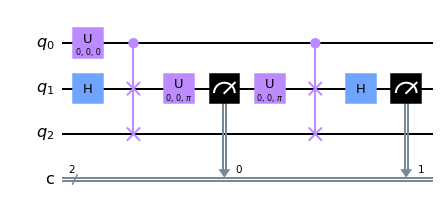

In [4]:
# draw quantum circuit
qc = make_qkd_qc(0, 1, 1, pi * 0)
qc.draw(output="mpl")


In [5]:
# test: Ordinary measurement method of eavesdropper
calc_statistics(1, 0)


(0.74853515625,
 0.7493943798449613,
 0.7552903543307087,
 0.501953125,
 0.498046875,
 0.7523193359375)

## 3. Result of performance evaluation

Amber colored dot shows the performance of ordinary eavesdropper in Figure 1.
Figure 1 shows that eavesdropper with angle is better than ordinary eavesdropper in regards to P(Alice == Bob) and P(Bob == Eve).

For example, P(Alice == Bob) and P(Bob == Eve) of eavesdropper with angle is 0.8 and 0.78 (at most) respectively when swap p is 0.2. 

In [6]:
p_list, angle_list, p_acc_mat, p_suc_mat = eval_performance()
p_suc_mat = np.abs(p_suc_mat - 0.5) + 0.5


In [7]:
def plot_suc_vs_acc(p_list, p_acc_mat, p_suc_mat):
    for p_idx in range(len(p_acc_mat)):
        plt.plot(
            p_acc_mat[p_idx], p_suc_mat[p_idx], label=f"swap_p={1-p_list[p_idx]:.1f}"
        )
    plt.plot([0.75], [0.75], marker="o", markersize=10)
    plt.xlabel("P(Alice == Bob)")
    plt.ylabel("P(Bob == Eve)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)


def plot_suc_vs_angle(p_list, angle_list, p_suc_mat):
    for p_idx in range(len(p_acc_mat)):
        plt.plot(angle_list, p_suc_mat[p_idx], label=f"swap_p={1-p_list[p_idx]:.1f}")
    plt.xlabel("theta")
    plt.ylabel("P(Bob == Eve)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)


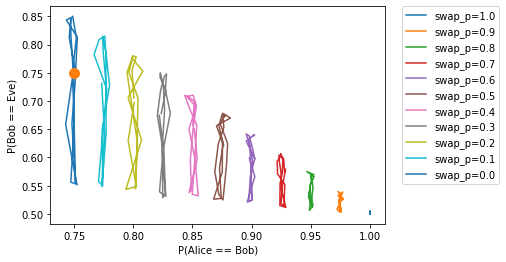

In [8]:
# Figure 1
plot_suc_vs_acc(p_list, p_acc_mat, p_suc_mat)


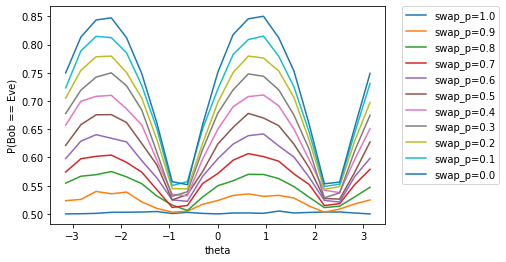

In [9]:
# Figure 2
plot_suc_vs_angle(p_list, angle_list, p_suc_mat)
